# Tutorial 3 — Volatility-Based Alphas

## Overview

The **low-volatility anomaly** is one of the most puzzling findings in
empirical asset pricing: stocks with *lower* volatility have historically
delivered **higher risk-adjusted returns** than their high-volatility
counterparts (Baker, Bradley & Wurgler, 2011).  This contradicts the
textbook prediction that higher risk should be rewarded with higher return.

Key explanations include **leverage constraints** (Frazzini & Pedersen, 2014),
**lottery preference** (Bali, Cakici & Whitelaw, 2011), and
**benchmarking incentives** that push managers toward high-beta stocks.

This tutorial covers:
1. Setup and data loading.
2. The low-volatility anomaly — comparing four volatility estimators and backtesting.
3. Betting against beta — BAB, idiosyncratic volatility, and comparative Sharpe ratios.
4. Volatility timing — scaling a momentum strategy to target constant 10% vol.
5. Risk-adjusted signals — the profitability proxy (rolling Sharpe ratio).
6. What can go wrong — quintile transitions, sector bets, crowding, leverage.
7. Summary table across all strategies.

## 1. Setup and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (12, 5), "figure.dpi": 100,
                     "axes.grid": True, "grid.alpha": 0.3})

from qlab.data import YFinanceProvider, ParquetCache
from qlab.features import (simple_returns, log_returns, rank, zscore, demean,
                            realized_volatility, ewm_volatility,
                            parkinson_volatility, garman_klass_volatility)
from qlab.features.rolling import rolling_beta, rolling_mean, rolling_std
from qlab.alphas import (low_volatility, idiosyncratic_vol, beta_signal,
                          momentum, profitability_proxy)
from qlab.portfolio import equal_weight_long_short, normalize_weights, proportional_weights
from qlab.backtest import run_backtest, BacktestConfig
from qlab.risk import performance_summary, drawdown_series, factor_regression, RegressionResult

TICKERS = [
    "AAPL", "MSFT", "GOOG", "AMZN", "META",
    "JPM", "GS", "BAC",
    "JNJ", "PFE", "UNH",
    "XOM", "CVX",
    "PG", "KO", "WMT",
    "HD", "NKE",
    "CAT", "HON",
]
START, END = "2018-01-01", "2024-12-31"

provider = ParquetCache(YFinanceProvider(), cache_dir=".qlab_cache")
prices = provider.fetch(TICKERS, START, END)
close = prices["adj_close"]
print(f"Universe : {close.index.get_level_values('ticker').nunique()} stocks")
print(f"Date range: {close.index.get_level_values('date').min().date()} to "
      f"{close.index.get_level_values('date').max().date()}")
print(f"Total obs : {len(close):,}")

Universe : 20 stocks
Date range: 2018-01-02 to 2024-12-30
Total obs : 35,200


## 2. The low-volatility anomaly

### Comparing four volatility estimators

| Estimator | Inputs | Relative Efficiency |
|-----------|--------|---------------------|
| **Close-to-close** (realised) | Close prices | 1x (baseline) |
| **EWM** (exponentially weighted) | Close prices | Reacts faster to recent data |
| **Parkinson** (1980) | High, Low | ~5x more efficient than CC |
| **Garman-Klass** (1980) | Open, High, Low, Close | ~8x more efficient than CC |

All estimators are computed over a **21-day rolling window** and
annualised by multiplying by $\sqrt{252}$.

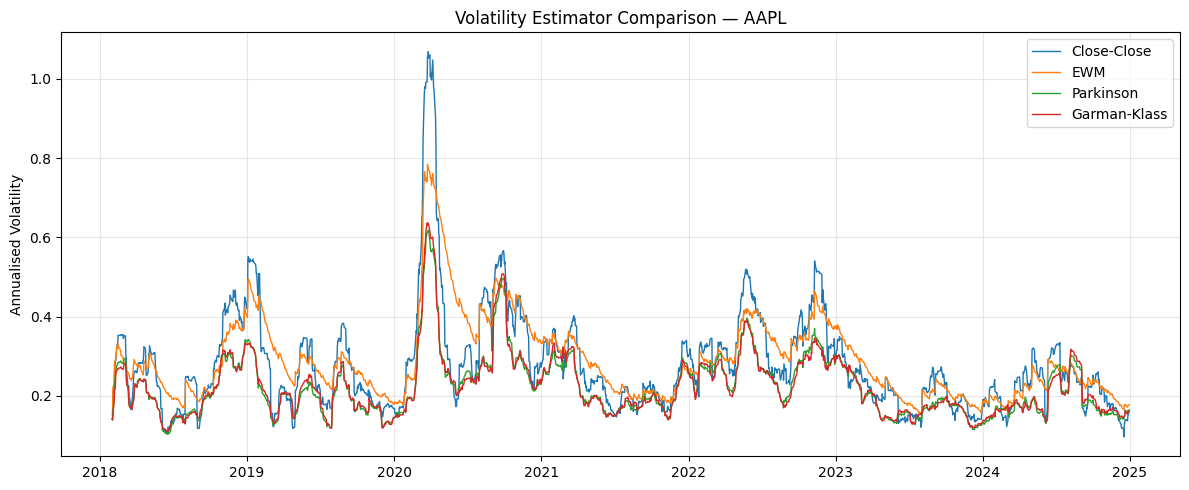

In [2]:
# Daily log returns for close-close and EWM estimators
rets = log_returns(close)

# Four volatility estimators (21-day, annualised)
vol_cc   = realized_volatility(rets, window=21, annualize=True)
vol_ewm  = ewm_volatility(rets, halflife=21, annualize=True)
vol_park = parkinson_volatility(prices["high"], prices["low"], window=21, annualize=True)
vol_gk   = garman_klass_volatility(prices["open"], prices["high"],
                                    prices["low"], prices["close"],
                                    window=21, annualize=True)

# Visual comparison for a single stock
ticker = "AAPL"
fig, ax = plt.subplots(figsize=(12, 5))
for label, vol in [("Close-Close", vol_cc), ("EWM", vol_ewm),
                    ("Parkinson", vol_park), ("Garman-Klass", vol_gk)]:
    ts = vol.xs(ticker, level="ticker").dropna()
    ax.plot(ts.index, ts.values, label=label, linewidth=1)
ax.set_ylabel("Annualised Volatility")
ax.set_title(f"Volatility Estimator Comparison — {ticker}")
ax.legend()
plt.tight_layout()
plt.show()

### Cross-sectional correlation heatmap between estimators

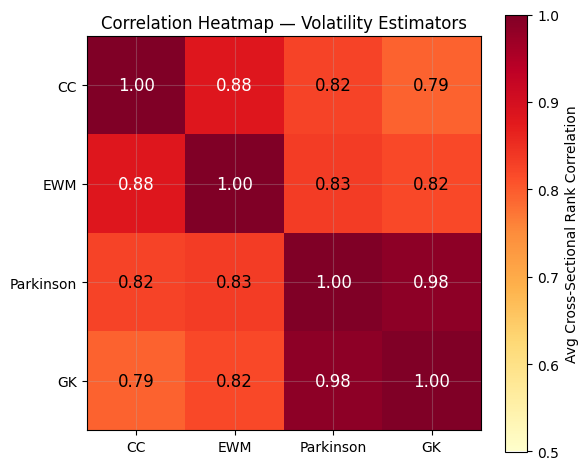

All four estimators are highly correlated cross-sectionally.
Parkinson and Garman-Klass capture intraday range information,
making them more efficient (lower estimation error) than close-to-close.


In [3]:
# Compute average cross-sectional rank correlation between all estimator pairs
from qlab.utils.alignment import unstack_to_wide

vol_dict = {"CC": vol_cc, "EWM": vol_ewm, "Parkinson": vol_park, "GK": vol_gk}
vol_wide = {}
for name, v in vol_dict.items():
    vol_wide[name] = unstack_to_wide(v.dropna())

# Find common dates and tickers across all estimators
common_dates = vol_wide["CC"].dropna(how="all").index
for name in vol_wide:
    common_dates = common_dates.intersection(vol_wide[name].dropna(how="all").index)
common_tickers = vol_wide["CC"].columns
for name in vol_wide:
    common_tickers = common_tickers.intersection(vol_wide[name].columns)

estimator_names = list(vol_dict.keys())
n_est = len(estimator_names)
corr_matrix = np.ones((n_est, n_est))

for i in range(n_est):
    for j in range(i + 1, n_est):
        corrs = []
        w_i = vol_wide[estimator_names[i]].reindex(index=common_dates, columns=common_tickers)
        w_j = vol_wide[estimator_names[j]].reindex(index=common_dates, columns=common_tickers)
        for date in common_dates[::5]:  # sample every 5th date for speed
            row_i = w_i.loc[date].dropna()
            row_j = w_j.loc[date].dropna()
            common_t = row_i.index.intersection(row_j.index)
            if len(common_t) >= 5:
                corrs.append(row_i[common_t].corr(row_j[common_t]))
        avg_corr = np.nanmean(corrs) if corrs else np.nan
        corr_matrix[i, j] = avg_corr
        corr_matrix[j, i] = avg_corr

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr_matrix, vmin=0.5, vmax=1.0, cmap="YlOrRd")
ax.set_xticks(range(n_est))
ax.set_xticklabels(estimator_names)
ax.set_yticks(range(n_est))
ax.set_yticklabels(estimator_names)
for i in range(n_est):
    for j in range(n_est):
        ax.text(j, i, f"{corr_matrix[i, j]:.2f}", ha="center", va="center",
                color="white" if corr_matrix[i, j] > 0.85 else "black", fontsize=12)
fig.colorbar(im, ax=ax, label="Avg Cross-Sectional Rank Correlation")
ax.set_title("Correlation Heatmap — Volatility Estimators")
plt.tight_layout()
plt.show()

print("All four estimators are highly correlated cross-sectionally.")
print("Parkinson and Garman-Klass capture intraday range information,")
print("making them more efficient (lower estimation error) than close-to-close.")

### Low-volatility signal and backtest

The `low_volatility` alpha returns **negative realised vol** (252-day window)
so that lower-volatility stocks receive a higher score.  We build a quintile
long/short portfolio: long the lowest-vol 20%, short the highest-vol 20%.

Signal coverage: 1508 dates


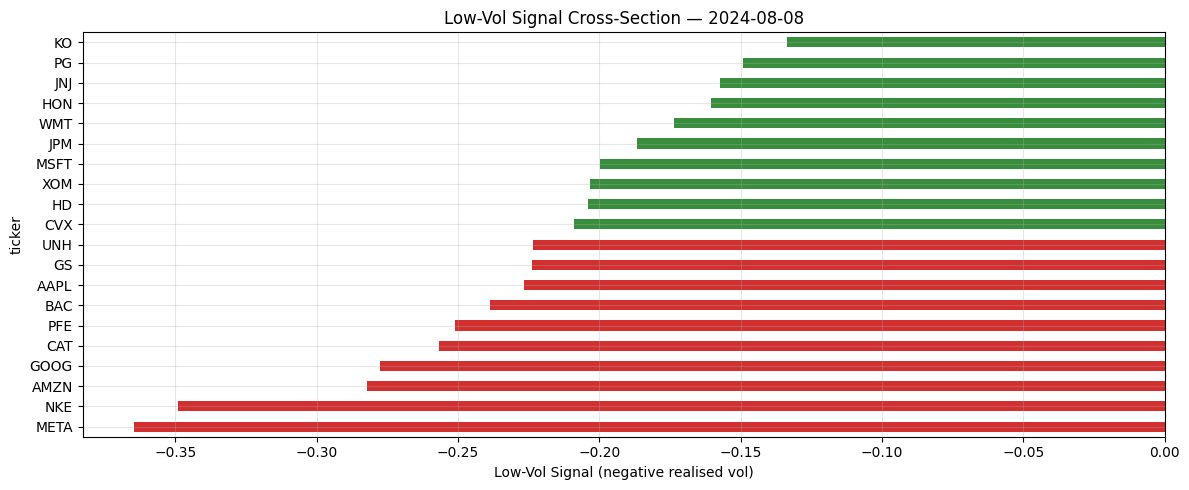

In [4]:
# Low-vol signal (252-day lookback, uses close-close vol internally)
sig_lowvol = low_volatility(close, lookback=252)
print(f"Signal coverage: {sig_lowvol.dropna().index.get_level_values('date').nunique()} dates")

# Cross-section snapshot
sample_date = sig_lowvol.dropna().index.get_level_values("date").unique()[-100]
cross = sig_lowvol.loc[sample_date].sort_values()

fig, ax = plt.subplots()
cross.plot.barh(ax=ax, color=["#d32f2f" if v < cross.median() else "#388e3c" for v in cross.values])
ax.set_xlabel("Low-Vol Signal (negative realised vol)")
ax.set_title(f"Low-Vol Signal Cross-Section — {sample_date.date()}")
plt.tight_layout()
plt.show()

In [5]:
# Portfolio construction and backtest
weights_lv = equal_weight_long_short(sig_lowvol.dropna(), long_pct=0.2, short_pct=0.2)
weights_lv = normalize_weights(weights_lv, gross_exposure=2.0, net_exposure=0.0)

config = BacktestConfig(
    rebalance_freq="monthly", commission_bps=5.0, slippage_bps=5.0,
    signal_lag=1, execution_price="open",
)
result_lv = run_backtest(weights_lv, prices, config=config)
summary_lv = performance_summary(result_lv.portfolio_returns)

print("Low-Volatility strategy backtest — real US equities:")
for k, v in summary_lv.items():
    print(f"  {k:25s}: {v:>10.4f}")

Low-Volatility strategy backtest — real US equities:
  total_return             :    -0.6826
  annualized_return        :    -0.1515
  annualized_volatility    :     0.2285
  sharpe_ratio             :    -0.6630
  sortino_ratio            :    -0.8656
  calmar_ratio             :    -0.2142
  max_drawdown             :    -0.7074
  hit_rate                 :     0.4131
  profit_factor            :     0.8933
  num_days                 :  1760.0000


## 3. Betting against beta

Frazzini & Pedersen (2014) show that *leverage-constrained* investors
overweight high-beta stocks, pushing their prices above fair value.  The
**Betting Against Beta (BAB)** factor goes long low-beta stocks and short
high-beta stocks:

$$\text{BAB}_i = -\beta_i$$

We also compute **idiosyncratic volatility**: the volatility of residuals
after removing market-beta exposure.  High idio-vol stocks tend to
underperform (Ang, Hodrick, Xing & Zhang, 2006), likely driven by
lottery-preference bias.

| Signal | What it captures |
|--------|-----------------|
| Low-Vol | Total volatility (systematic + idiosyncratic) |
| BAB | Systematic risk only (market beta) |
| Idio-Vol | Residual risk after removing beta exposure |

In [6]:
# Market price proxy: equal-weighted average of our universe
# This gives a Series indexed by date only (not MultiIndex)
mkt_prices = close.groupby(level="date").mean()
print(f"Market proxy: {len(mkt_prices)} dates, equal-weighted across {len(TICKERS)} stocks")

# BAB signal (negative beta)
sig_bab = beta_signal(close, mkt_prices, lookback=252)

# Idiosyncratic vol signal (negative idio vol)
sig_idiovol = idiosyncratic_vol(close, mkt_prices, lookback=252)

# Summary stats for all three signals
for name, sig in [("BAB (neg beta)", sig_bab),
                   ("Idio-Vol", sig_idiovol),
                   ("Low-Vol", sig_lowvol)]:
    s = sig.dropna()
    print(f"{name:20s}: mean={s.mean():+.4f}  std={s.std():.4f}  "
          f"coverage={s.index.get_level_values('date').nunique()} dates")

Market proxy: 1760 dates, equal-weighted across 20 stocks
BAB (neg beta)      : mean=-0.9407  std=0.3674  coverage=1508 dates
Idio-Vol            : mean=-0.2148  std=0.0601  coverage=1257 dates
Low-Vol             : mean=-0.2834  std=0.1000  coverage=1508 dates


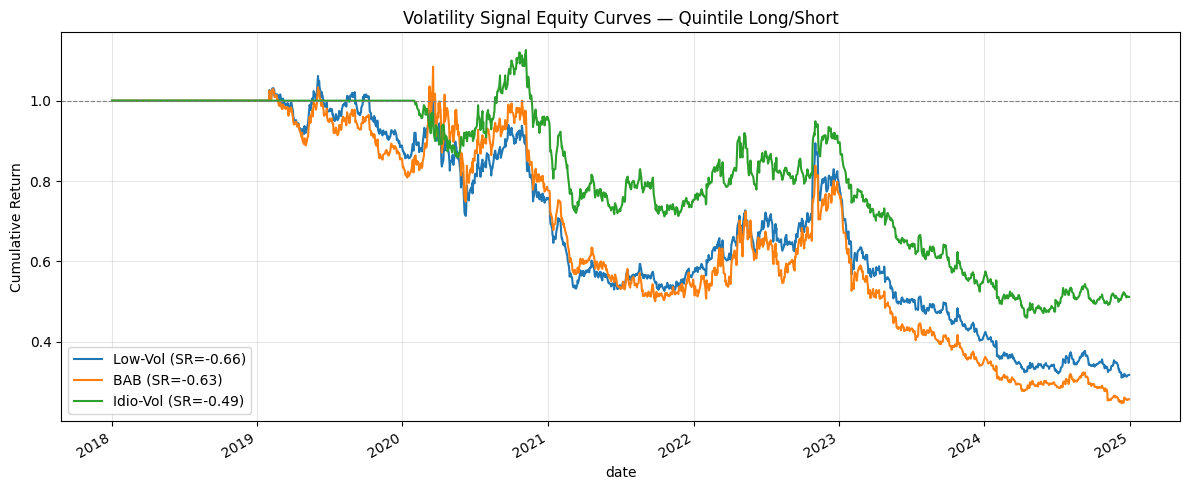

In [7]:
# Backtest all three volatility signals
results_vol = {}
summaries_vol = {}

for name, sig in [("Low-Vol", sig_lowvol),
                   ("BAB", sig_bab),
                   ("Idio-Vol", sig_idiovol)]:
    w = equal_weight_long_short(sig.dropna(), long_pct=0.2, short_pct=0.2)
    w = normalize_weights(w, gross_exposure=2.0, net_exposure=0.0)
    res = run_backtest(w, prices, config=config)
    results_vol[name] = res
    summaries_vol[name] = performance_summary(res.portfolio_returns)

# Equity curves
fig, ax = plt.subplots(figsize=(12, 5))
for name, res in results_vol.items():
    cum = (1 + res.portfolio_returns).cumprod()
    sr = summaries_vol[name]["sharpe_ratio"]
    cum.plot(ax=ax, label=f"{name} (SR={sr:.2f})", linewidth=1.5)
ax.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)
ax.set_ylabel("Cumulative Return")
ax.set_title("Volatility Signal Equity Curves — Quintile Long/Short")
ax.legend()
plt.tight_layout()
plt.show()

### Sharpe ratio comparison

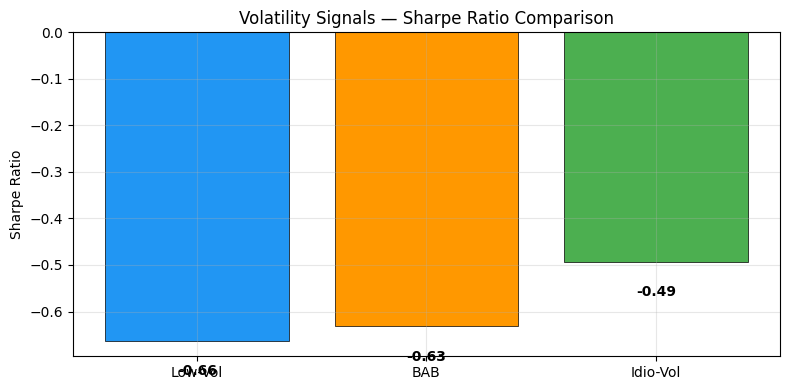

Signal         Ann.Ret   Ann.Vol    Sharpe     MaxDD
-------------------------------------------------------
Low-Vol         -0.152     0.229    -0.663    -0.707
BAB             -0.177     0.280    -0.632    -0.773
Idio-Vol        -0.092     0.186    -0.493    -0.592


In [8]:
# Bar chart comparing Sharpe ratios across the three vol signals
fig, ax = plt.subplots(figsize=(8, 4))
names = list(summaries_vol.keys())
sharpes = [summaries_vol[n]["sharpe_ratio"] for n in names]
colors = ["#2196F3", "#FF9800", "#4CAF50"]
bars = ax.bar(names, sharpes, color=colors, edgecolor="black", linewidth=0.5)
for bar, sr in zip(bars, sharpes):
    ypos = sr + 0.02 if sr >= 0 else sr - 0.05
    ax.text(bar.get_x() + bar.get_width() / 2, ypos,
            f"{sr:.2f}", ha="center", va="bottom" if sr >= 0 else "top",
            fontweight="bold")
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Volatility Signals — Sharpe Ratio Comparison")
ax.axhline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.show()

# Print full comparison
print(f"{'Signal':<12s}  {'Ann.Ret':>8s}  {'Ann.Vol':>8s}  {'Sharpe':>8s}  {'MaxDD':>8s}")
print("-" * 55)
for name in names:
    s = summaries_vol[name]
    print(f"{name:<12s}  {s['annualized_return']:>8.3f}  {s['annualized_volatility']:>8.3f}  "
          f"{s['sharpe_ratio']:>8.3f}  {s['max_drawdown']:>8.3f}")

## 4. Volatility timing

**Idea**: use volatility not as a cross-sectional signal, but as a
**time-series portfolio scaler**.  Scale a strategy's weights by the
inverse of its trailing realised volatility to target a constant
annualised volatility (here 10%):

$$w_t^{\text{scaled}} = w_t^{\text{raw}} \times \frac{\sigma_{\text{target}}}{\hat{\sigma}_t}$$

When aggregate volatility is high (e.g., March 2020), reduce exposure.
When volatility is low, scale up.  We use the **momentum** signal as
the base strategy and compare raw vs vol-targeted equity curves.

In [9]:
# Base signal: 12-1 momentum
sig_mom = momentum(close, lookback=252, skip=21)
weights_mom = equal_weight_long_short(sig_mom.dropna(), long_pct=0.2, short_pct=0.2)
weights_mom = normalize_weights(weights_mom, gross_exposure=2.0, net_exposure=0.0)

# Raw momentum backtest
result_mom_raw = run_backtest(weights_mom, prices, config=config)

# Compute trailing 63-day portfolio vol (annualised)
port_ret_raw = result_mom_raw.portfolio_returns
trailing_vol = port_ret_raw.rolling(63, min_periods=21).std() * np.sqrt(252)

# Vol-target: scale returns by (target_vol / trailing_vol)
# In practice you would rescale weights before execution; here we scale
# returns for a cleaner illustration of the vol-targeting effect.
VOL_TARGET = 0.10  # 10% annualised
vol_scalar = VOL_TARGET / trailing_vol.clip(lower=0.01)
vol_scalar = vol_scalar.clip(upper=3.0)  # cap leverage at 3x

port_ret_voltgt = port_ret_raw * vol_scalar.shift(1)  # use prior day's scalar
port_ret_voltgt = port_ret_voltgt.dropna()

print(f"Raw momentum realised vol:   {port_ret_raw.std() * np.sqrt(252):.3f}")
print(f"Vol-targeted realised vol:   {port_ret_voltgt.std() * np.sqrt(252):.3f}")
print(f"Target vol:                  {VOL_TARGET:.3f}")

Raw momentum realised vol:   0.239
Vol-targeted realised vol:   0.105
Target vol:                  0.100


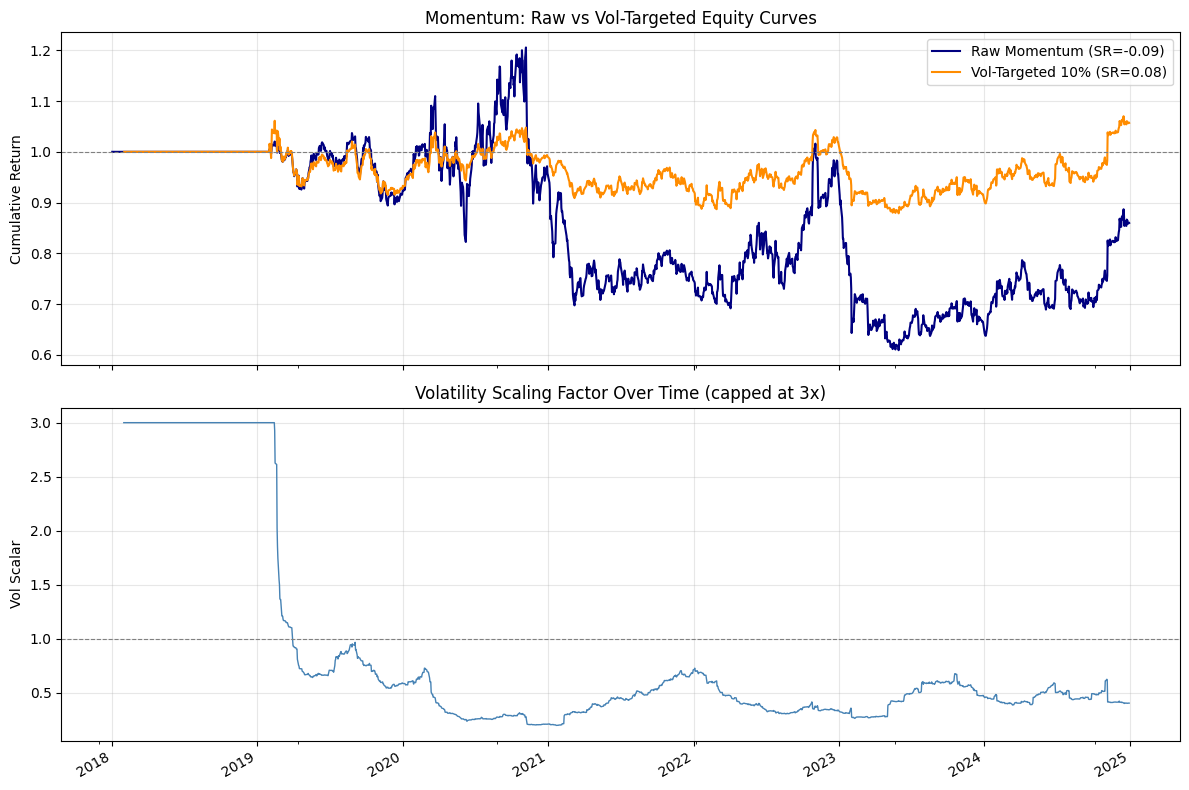


Raw momentum performance:
  total_return             :    -0.1402
  annualized_return        :    -0.0214
  annualized_volatility    :     0.2386
  sharpe_ratio             :    -0.0897
  sortino_ratio            :    -0.1058
  calmar_ratio             :    -0.0432
  max_drawdown             :    -0.4949
  hit_rate                 :     0.4381
  profit_factor            :     1.0058
  num_days                 :  1760.0000

Vol-targeted performance:
  total_return             :     0.0571
  annualized_return        :     0.0081
  annualized_volatility    :     0.1049
  sharpe_ratio             :     0.0770
  sortino_ratio            :     0.0978
  calmar_ratio             :     0.0470
  max_drawdown             :    -0.1719
  hit_rate                 :     0.4434
  profit_factor            :     1.0248
  num_days                 :  1739.0000


In [10]:
# Compare equity curves: raw momentum vs vol-targeted
cum_raw = (1 + port_ret_raw).cumprod()
cum_voltgt = (1 + port_ret_voltgt).cumprod()

sr_raw = performance_summary(port_ret_raw)["sharpe_ratio"]
sr_voltgt = performance_summary(port_ret_voltgt)["sharpe_ratio"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Equity curves
cum_raw.plot(ax=ax1, label=f"Raw Momentum (SR={sr_raw:.2f})", color="navy", linewidth=1.5)
cum_voltgt.plot(ax=ax1, label=f"Vol-Targeted 10% (SR={sr_voltgt:.2f})", color="darkorange", linewidth=1.5)
ax1.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)
ax1.set_ylabel("Cumulative Return")
ax1.set_title("Momentum: Raw vs Vol-Targeted Equity Curves")
ax1.legend()

# Volatility scaling factor over time
vol_scalar.plot(ax=ax2, color="steelblue", linewidth=1)
ax2.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)
ax2.set_ylabel("Vol Scalar")
ax2.set_title("Volatility Scaling Factor Over Time (capped at 3x)")
ax2.set_xlabel("")
plt.tight_layout()
plt.show()

print(f"\nRaw momentum performance:")
for k, v in performance_summary(port_ret_raw).items():
    print(f"  {k:25s}: {v:>10.4f}")
print(f"\nVol-targeted performance:")
for k, v in performance_summary(port_ret_voltgt).items():
    print(f"  {k:25s}: {v:>10.4f}")

## 5. Risk-adjusted signals

The `profitability_proxy` signal computes a **rolling Sharpe ratio** per
stock:

$$\text{Quality}_i = \frac{\bar{r}_i}{\sigma_i}$$

over a trailing 252-day window.  Stocks with high risk-adjusted returns
are treated as higher-quality names.

This is a cross between a momentum signal (rewarding high $\bar{r}$) and
a low-vol signal (penalising high $\sigma$).  It selects consistent,
low-variance winners rather than rewarding raw performance alone.

In [11]:
# Profitability proxy signal
sig_prof = profitability_proxy(close, lookback=252)

# Cross-sectional rank correlations with momentum and low-vol
from qlab.features.cross_section import rank as cs_rank

r_prof = cs_rank(sig_prof.dropna())
r_mom = cs_rank(sig_mom.dropna())
r_lowvol = cs_rank(sig_lowvol.dropna())

# Align on common index
common_idx = r_prof.index.intersection(r_mom.index).intersection(r_lowvol.index)
r_prof_c = r_prof.reindex(common_idx)
r_mom_c = r_mom.reindex(common_idx)
r_lowvol_c = r_lowvol.reindex(common_idx)

# Average daily cross-sectional rank correlations
corr_prof_mom = r_prof_c.groupby(level="date").corr(r_mom_c).mean()
corr_prof_lv = r_prof_c.groupby(level="date").corr(r_lowvol_c).mean()
corr_mom_lv = r_mom_c.groupby(level="date").corr(r_lowvol_c).mean()

print("Average cross-sectional rank correlations:")
print(f"  Profitability vs Momentum:    {corr_prof_mom:.3f}")
print(f"  Profitability vs Low-Vol:     {corr_prof_lv:.3f}")
print(f"  Momentum vs Low-Vol:          {corr_mom_lv:.3f}")
print()
print("Profitability is a blend: positively correlated with both momentum")
print("and low-vol, but penalises noisy winners and rewards steady compounders.")

Average cross-sectional rank correlations:
  Profitability vs Momentum:    0.903
  Profitability vs Low-Vol:     0.130
  Momentum vs Low-Vol:          0.012

Profitability is a blend: positively correlated with both momentum
and low-vol, but penalises noisy winners and rewards steady compounders.


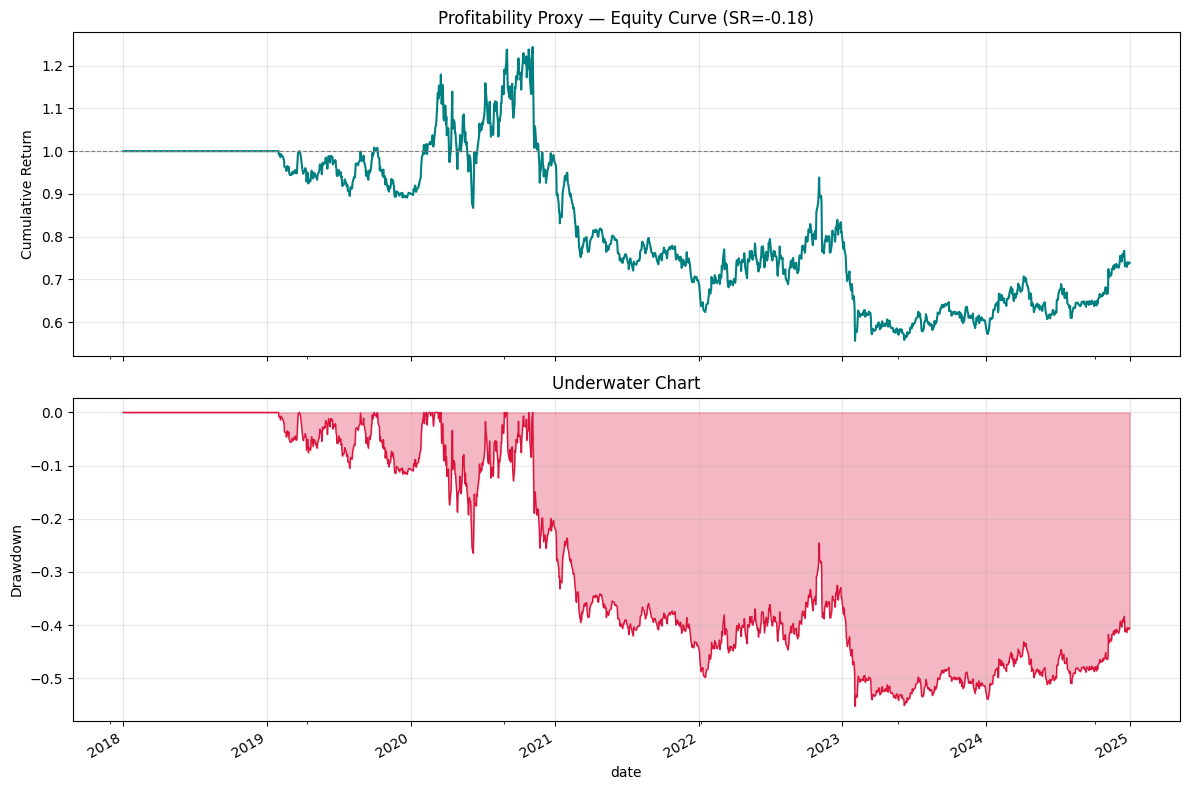

Profitability proxy backtest:
  total_return             :    -0.2611
  annualized_return        :    -0.0424
  annualized_volatility    :     0.2405
  sharpe_ratio             :    -0.1763
  sortino_ratio            :    -0.2054
  calmar_ratio             :    -0.0767
  max_drawdown             :    -0.5527
  hit_rate                 :     0.4267
  profit_factor            :     0.9887
  num_days                 :  1760.0000


In [12]:
# Backtest profitability proxy
weights_prof = equal_weight_long_short(sig_prof.dropna(), long_pct=0.2, short_pct=0.2)
weights_prof = normalize_weights(weights_prof, gross_exposure=2.0, net_exposure=0.0)
result_prof = run_backtest(weights_prof, prices, config=config)
summary_prof = performance_summary(result_prof.portfolio_returns)

# Equity curve with drawdown
cum_prof = (1 + result_prof.portfolio_returns).cumprod()
dd_prof = drawdown_series(result_prof.portfolio_returns)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

cum_prof.plot(ax=ax1, color="teal", linewidth=1.5)
ax1.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)
ax1.set_ylabel("Cumulative Return")
ax1.set_title(f"Profitability Proxy — Equity Curve (SR={summary_prof['sharpe_ratio']:.2f})")

dd_prof.plot(ax=ax2, color="crimson", linewidth=1)
ax2.fill_between(dd_prof.index, dd_prof.values, 0, alpha=0.3, color="crimson")
ax2.set_ylabel("Drawdown")
ax2.set_title("Underwater Chart")
plt.tight_layout()
plt.show()

print("Profitability proxy backtest:")
for k, v in summary_prof.items():
    print(f"  {k:25s}: {v:>10.4f}")

## 6. What can go wrong

### Volatility quintile transition matrix

How stable are volatility rankings?  If stocks frequently jump between
quintiles, the signal has poor persistence and turnover will be high.
The transition matrix below shows the probability of moving from one
volatility quintile to another over a one-month horizon.

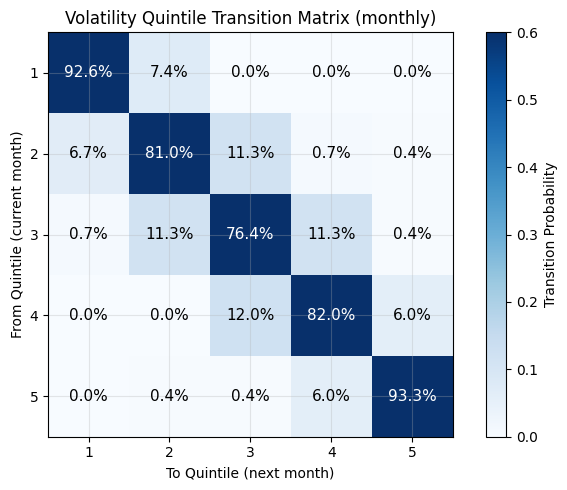

Diagonal average (persistence): 85.1%
Higher diagonal = more persistent vol ranking = lower turnover cost.


In [13]:
# Assign quintile labels (1 = lowest vol, 5 = highest vol) using 252-day realised vol
vol_252 = realized_volatility(rets, window=252, annualize=True).dropna()

def assign_quintile(group):
    try:
        return pd.qcut(group.rank(method="first"), 5, labels=[1, 2, 3, 4, 5]).astype(int)
    except ValueError:
        return pd.Series(np.nan, index=group.index)

quintiles = vol_252.groupby(level="date").transform(assign_quintile)

# Monthly transition matrix: compare quintile at month-end to quintile ~21 days later
dates = quintiles.dropna().index.get_level_values("date").unique().sort_values()
monthly_dates = dates[::21]  # sample approximately monthly

transitions = []
for i in range(len(monthly_dates) - 1):
    d0, d1 = monthly_dates[i], monthly_dates[i + 1]
    try:
        q0 = quintiles.loc[d0]
        q1 = quintiles.loc[d1]
        common = q0.dropna().index.intersection(q1.dropna().index)
        if len(common) >= 10:
            for t in common:
                transitions.append((int(q0.loc[t]), int(q1.loc[t])))
    except KeyError:
        continue

trans_df = pd.DataFrame(transitions, columns=["from_q", "to_q"])
trans_matrix = pd.crosstab(trans_df["from_q"], trans_df["to_q"], normalize="index")
trans_matrix.index.name = "From Quintile"
trans_matrix.columns.name = "To Quintile"

fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(trans_matrix.values, cmap="Blues", vmin=0, vmax=0.6)
for i in range(5):
    for j in range(5):
        val = trans_matrix.values[i, j]
        ax.text(j, i, f"{val:.1%}", ha="center", va="center",
                color="white" if val > 0.35 else "black", fontsize=11)
ax.set_xticks(range(5))
ax.set_xticklabels([1, 2, 3, 4, 5])
ax.set_yticks(range(5))
ax.set_yticklabels([1, 2, 3, 4, 5])
ax.set_xlabel("To Quintile (next month)")
ax.set_ylabel("From Quintile (current month)")
ax.set_title("Volatility Quintile Transition Matrix (monthly)")
fig.colorbar(im, ax=ax, label="Transition Probability")
plt.tight_layout()
plt.show()

diag_avg = np.diag(trans_matrix.values).mean()
print(f"Diagonal average (persistence): {diag_avg:.1%}")
print("Higher diagonal = more persistent vol ranking = lower turnover cost.")

### Key risks for volatility-based strategies

**Sector concentration**: Low-volatility portfolios tend to overweight
defensive sectors (utilities, consumer staples, healthcare) and underweight
cyclicals (technology, energy).  These unintended sector bets can dominate
returns, particularly during style rotations.

**Crowding**: The low-vol anomaly has attracted significant capital since
publication, especially through "smart beta" ETFs.  Crowded trades create
fragility: when investors unwind simultaneously, low-vol stocks experience
sharp drawdowns (as seen in late 2020 during the growth/value rotation).

**Leverage constraints**: BAB in its pure form requires shorting high-beta
stocks and leveraging low-beta stocks.  In practice, margin requirements,
short-borrowing costs, and funding constraints erode the theoretical edge.

**Rate sensitivity**: Low-volatility stocks are often "bond proxies" with
high duration.  Rising interest rates (e.g., 2022) can cause coordinated
losses across the low-vol universe, overwhelming the cross-sectional signal.

**Rebalancing costs**: The transition matrix above shows moderate quintile
persistence.  Frequent rebalancing adds transaction costs; infrequent
rebalancing lets the portfolio drift from target exposures.  Monthly
rebalancing is a reasonable compromise for volatility signals.

## 7. Summary

In [14]:
# Compile summary table across all strategies tested in this tutorial
all_strategies = {
    "Low-Vol": result_lv,
    "BAB": results_vol["BAB"],
    "Idio-Vol": results_vol["Idio-Vol"],
    "Profitability": result_prof,
    "Momentum (raw)": result_mom_raw,
}

rows = []
for name, res in all_strategies.items():
    s = performance_summary(res.portfolio_returns)
    rows.append({
        "Strategy": name,
        "Ann. Return": f"{s['annualized_return']:.2%}",
        "Ann. Vol": f"{s['annualized_volatility']:.2%}",
        "Sharpe": f"{s['sharpe_ratio']:.2f}",
        "Sortino": f"{s['sortino_ratio']:.2f}",
        "Max DD": f"{s['max_drawdown']:.2%}",
        "Calmar": f"{s['calmar_ratio']:.2f}",
        "Hit Rate": f"{s['hit_rate']:.1%}",
    })

summary_table = pd.DataFrame(rows).set_index("Strategy")
print("=== Strategy Comparison ===")
print(summary_table.to_string())

=== Strategy Comparison ===
               Ann. Return Ann. Vol Sharpe Sortino   Max DD Calmar Hit Rate
Strategy                                                                   
Low-Vol            -15.15%   22.85%  -0.66   -0.87  -70.74%  -0.21    41.3%
BAB                -17.70%   28.00%  -0.63   -0.80  -77.26%  -0.23    41.8%
Idio-Vol            -9.15%   18.58%  -0.49   -0.62  -59.19%  -0.15    35.2%
Profitability       -4.24%   24.05%  -0.18   -0.21  -55.27%  -0.08    42.7%
Momentum (raw)      -2.14%   23.86%  -0.09   -0.11  -49.49%  -0.04    43.8%


### Key takeaways

| Concept | Takeaway |
|---------|----------|
| Low-vol anomaly | Lower-risk stocks have historically earned higher risk-adjusted returns |
| Vol estimators | Parkinson and GK are more efficient, but all are highly correlated cross-sectionally |
| BAB | Betting against beta isolates the leverage-constraint channel; requires actual leverage |
| Idio-vol | Removing market exposure isolates stock-specific risk; captures lottery preference |
| Vol timing | Scaling by inverse trailing vol stabilises equity curves and can improve Sharpe |
| Profitability proxy | Rolling Sharpe ratio blends momentum and low-vol into a quality-like signal |
| Risks | Sector concentration, crowding, rate sensitivity, leverage constraints |

The next tutorial shows how to **combine** momentum, mean reversion, and
volatility signals into a multi-factor composite.